### WOA18 versus PHC2

This notebooks compares annual mean climatologies for potential temperature and salinity from WOA18 versus PHC2. Both products have been horizontally remapped to the tx0.6v1 grid. In adddition, the WOA18 product was linearly interpolated to the same vertical grid as PHC2 to facilitate the comparison.

In [28]:
%matplotlib inline

In [2]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import seaborn, matplotlib
from collections import OrderedDict
import warnings, os
from mom6_tools.MOM6grid import MOM6grid
from mom6_tools.stats import stats_to_ds, min_da, max_da, mean_da, rms_da, std_da
from mom6_tools.m6toolbox import genBasinMasks
from mom6_tools.m6plot import xyplot, xycompare, chooseColorLevels
warnings.filterwarnings("ignore")
matplotlib.rcParams.update({'font.size': 14})

Basemap module not found. Some regional plots may not function properly


In [3]:
# load grid from a recent run
path = '/glade/scratch/gmarques/gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001/run/'
fname = path + 'gmom.e22.GJRAv3.TL319_t061_zstar_N63.mct.baseline.001.mom6.static.nc'
grd = MOM6grid(fname)
grd_xr = MOM6grid(fname, xrformat=True)

MOM6 grid successfully loaded... 

MOM6 grid successfully loaded... 



In [4]:
path = '/glade/u/home/gmarques/Notebooks/CESM_MOM6/WOA18_remapping/'
temp_woa18 = xr.open_dataset(path+'WOA18_TEMP_tx0.66v1_34lev_ann_avg.nc')
temp_woa18['xh'] = grd.xh; temp_woa18['yh'] = grd.yh
salt_woa18 = xr.open_dataset(path+'WOA18_SALT_tx0.66v1_34lev_ann_avg.nc')
salt_woa18['xh'] = grd.xh; salt_woa18['yh'] = grd.yh

In [5]:
path = '/glade/p/cesm/omwg/obs_data/phc/'
temp_phc2 = xr.open_dataset(path+'PHC2_TEMP_tx0.66v1_34lev_ann_avg.nc').rename({'X':'xh',
            'Y':'yh','TEMP':'theta0'})
temp_phc2['xh'] = grd.xh; temp_phc2['yh'] = grd.yh
salt_phc2 = xr.open_dataset(path+'PHC2_SALT_tx0.66v1_34lev_ann_avg.nc').rename({'X':'xh',
            'Y':'yh','SALT':'s_an'})
salt_phc2['xh'] = grd.xh; salt_phc2['yh'] = grd.yh

### Region masks

In [6]:
depth = grd.depth_ocean
# remote Nan's, otherwise genBasinMasks won't work
depth[np.isnan(depth)] = 0.0
basin_code = genBasinMasks(grd.geolon, grd.geolat, depth, xda=True)

11.16427964664149 64.78854837178643 [391, 434]


In [7]:
# workaround to remove a few basins
regions = np.array(['Global', 'MedSea',
       'BalticSea', 'HudsonBay', 'Arctic', 'PacificOcean',
       'AtlanticOcean', 'IndianOcean', 'SouthernOcean', 'LabSea',
       'BaffinBay'])
basin_code = basin_code.sel(region=regions)

In [8]:
fig, ax = plt.subplots(nrows=4, ncols=3, figsize=(20,18))
ax1 = ax.flatten()
for r in range(len(basin_code.region)):
  xyplot((basin_code[0,:]+basin_code[r,:]*2).values, grd.geolon, grd.geolat,
        title=str(basin_code['region'][r].values),colormap=None, axis=ax1[r],
        xlabel='',xunits='',ylabel='',yunits='')

### Contruct a 3D area

In [9]:
# construct a 3D area with land values masked
area = np.ma.masked_where(grd.wet == 0,grd.area_t)
tmp = np.repeat(area[np.newaxis, :, :], len(temp_phc2.depth), axis=0)
area_mom3D = xr.DataArray(tmp, dims=('depth', 'yh','xh'), 
                          coords={'depth':temp_phc2.depth.values, 'yh': grd.yh, 
                                  'xh':grd.xh})
for k in range(len(area_mom3D.depth)):
    area_mom3D[k,:] = grd_xr.area_t.where(grd_xr.depth_ocean >= area_mom3D.depth[k]) 

##### Make sure it is doing what we want

In [10]:
area_mom3D[25,:].plot()

In [11]:
area_mom3D[-2,:].plot()

### Functions

In [12]:
def myStats_da(da, weights, dims=('yh', 'xh'), basins=None, debug=False):
  rmask_od = OrderedDict()
  for reg in basins.region:
    if debug: print('Region: ', reg)
    # select region in the DataArray
    da_reg = da.where(basins.sel(region=reg).values == 1.0)
    # select weights to where region values are one
    tmp_weights = weights.where(basins.sel(region=reg).values == 1.0)
    total_weights = tmp_weights.sum(dim=dims)
    if debug:
        #print('tmp_weights',tmp_weights)
        print('total_weights',total_weights)

    da_min  = min_da(da_reg , dims)
    da_max  = max_da(da_reg , dims)
    da_mean = mean_da(da_reg, dims, tmp_weights,  total_weights)
    da_std  = std_da(da_reg , dims, tmp_weights,  total_weights, da_mean)
    da_rms  = rms_da(da_reg , dims, tmp_weights,  total_weights)
    out = stats_to_ds(da_min, da_max, da_mean, da_std, da_rms)
    rmask_od[str(reg.values)] = out

  #return rmask_od
  return dict_to_da(rmask_od) # create dataarray using rmask_od

In [13]:
def dict_to_da(stats_dict):
  depth = stats_dict[list(stats_dict.items())[0][0]].depth
  basins = list(stats_dict.keys())
  stats = ['da_min', 'da_max', 'da_mean', 'da_std', 'da_rms']
  var = np.zeros((len(basins),len(stats),len(depth)))
  da = xr.DataArray(var, dims=['basin', 'stats', 'depth'],
                           coords={'basin': basins,
                                   'stats': stats,
                                   'depth': depth},)
  for reg in (basins):
    da.sel(basin=reg).sel(stats='da_min').values[:] = stats_dict[reg].da_min.values
    da.sel(basin=reg).sel(stats='da_max').values[:] = stats_dict[reg].da_max.values
    da.sel(basin=reg).sel(stats='da_mean').values[:]= stats_dict[reg].da_mean.values
    da.sel(basin=reg).sel(stats='da_std').values[:] = stats_dict[reg].da_std.values
    da.sel(basin=reg).sel(stats='da_rms').values[:] = stats_dict[reg].da_rms.values

  return da

In [14]:
def score_plot3(x,y,vals, cmin=None, cmap=plt.cm.bwr,title='',nbins=50, units=''): 
  matplotlib.rcParams.update({'font.size': 14})
  reg = np.arange(len(x)+ 1) 
  autocenter=False  
  if not cmin:
    cmin = vals.min().values
    autocenter=True
    
  cmax = vals.max().values
  cmap, norm, extend = chooseColorLevels(cmin, cmax, cmap, 
                                         nbins=nbins, autocenter=autocenter) 
  #print(val_abs)
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,8), sharex=True)
  ax[0].set_title(title)    
  # 0 to 200 depth[0] to depth[9]
  cs = ax[2].pcolormesh(reg, y, vals.transpose().values, cmap=cmap, norm=norm)
  ax[2].set_xticks(np.arange(len(x))+0.5)
  ax[2].set_xticklabels(x);
  ax[2].set_ylim(0,200)
  ax[2].set_ylabel('Depth [m]')
  # 200 to 1000 
  cs = ax[1].pcolormesh(reg, y, vals.transpose().values, cmap=cmap, norm=norm)
  ax[1].set_xticks(np.arange(len(x))+0.5)
  ax[1].set_xticklabels(x);
  ax[1].set_ylim(200,1000)
  ax[1].set_ylabel('Depth [m]')

  # 1000 to 6000 
  cs = ax[0].pcolormesh(reg, y, vals.transpose().values, cmap=cmap, norm=norm)
  ax[0].set_xticks(np.arange(len(x))+0.5)
  ax[0].set_xticklabels(x);
  ax[0].set_ylim(1000,4000)
  ax[0].set_ylabel('Depth [m]')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax[2].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  cbar = fig.colorbar(cs, cax=cbar_ax)
  cbar.set_label(units)

  return

In [15]:
def score_plot2(x,y,vals, cmin=None, cmap=plt.cm.bwr,title='',nbins=50, units=''): 
  matplotlib.rcParams.update({'font.size': 14})
  reg = np.arange(len(x)+ 1) 
  autocenter=False  
  if not cmin:
    cmin = vals.min().values
    autocenter=True
    
  cmax = vals.max().values
  #print(cmin, autocenter)
  cmap, norm, extend = chooseColorLevels(cmin, cmax, cmap, 
                                         nbins=nbins, autocenter=autocenter) 
  #print(val_abs)
  fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10,5), sharex=True)
  ax[0].set_title(title)    
  # 0 to 200 depth[0] to depth[9]
  cs = ax[1].pcolormesh(reg, y, vals.transpose().values, cmap=cmap, norm=norm)
  ax[1].set_xticks(np.arange(len(x))+0.5)
  ax[1].set_xticklabels(x);
  ax[1].set_ylim(0,200)
  ax[1].set_ylabel('Depth [m]')
  # 200 to 1000 
  cs = ax[0].pcolormesh(reg, y, vals.transpose().values, cmap=cmap, norm=norm)
  ax[0].set_xticks(np.arange(len(x))+0.5)
  ax[0].set_xticklabels(x);
  ax[0].set_ylim(200,1000)
  ax[0].set_ylabel('Depth [m]')

  # Rotate the tick labels and set their alignment.
  plt.setp(ax[1].get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
  fig.subplots_adjust(right=0.8)
  cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
  cbar = fig.colorbar(cs, cax=cbar_ax)
  cbar.set_label(units)

  return

### Compute stats for each region

##### Temperature

In [30]:
diff = temp_woa18.theta0 - temp_phc2.theta0
temp_stats = myStats_da(diff, area_mom3D, basins=basin_code, debug=False)

In [17]:
# for plotting
depth = temp_stats.depth.values
basin = temp_stats.basin.values
interfaces = np.zeros(len(depth)+1)
for k in range(1,len(depth)+1):
    interfaces[k] = interfaces[k-1] + ( 2 * (depth[k-1] - interfaces[k-1]))
                                       
reg = np.arange(len(temp_stats.basin.values)+ 1) 

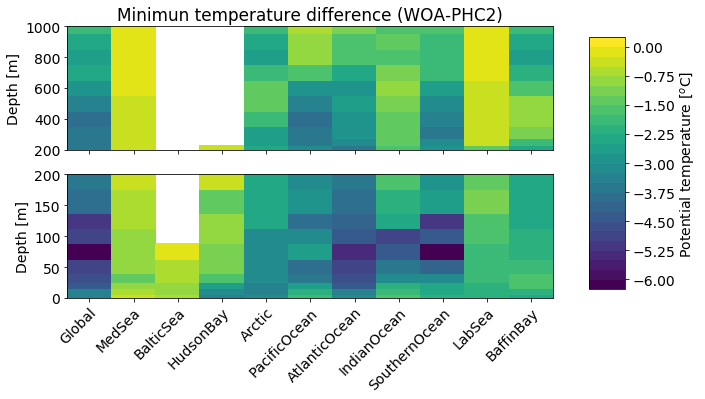

In [29]:
score_plot2(basin, interfaces, temp_stats[:,0,:],nbins=30, cmap=plt.cm.viridis, 
            cmin=temp_stats[:,0,:].min().values,
            units=r'Potential temperature [$^o$C]',title='Minimun temperature difference (WOA-PHC2)')

In [19]:
score_plot2(basin, interfaces, temp_stats[:,1,:],nbins=30, cmap=plt.cm.viridis, 
            cmin=temp_stats[:,1,:].min().values,
            units=r'Potential temperature [$^o$C]',title='Maximum temperature difference (WOA-PHC2)')

In [20]:
score_plot2(basin, interfaces, temp_stats[:,2,:],nbins=30, cmap=plt.cm.seismic, 
            units=r'Potential temperature [$^o$C]',title='Mean temperature difference (WOA-PHC2)')

In [21]:
score_plot2(basin, interfaces, temp_stats[:,3,:],nbins=30, cmap=plt.cm.viridis, cmin = 1.0E-15, 
            units=r'Potential temperature [$^o$C]',title='STD temperature difference (WOA-PHC2)')

In [22]:
score_plot2(basin, interfaces, temp_stats[:,4,:],nbins=30, cmap=plt.cm.viridis, cmin = 1.0E-15,
            units=r'Potential temperature [$^o$C]',title='RMS temperature difference (WOA-PHC2)')

##### Salinity

In [23]:
diff = salt_woa18.s_an - salt_phc2.s_an
salt_stats = myStats_da(diff, area_mom3D, basins=basin_code, debug=False)

In [24]:
score_plot2(basin, interfaces, salt_stats[:,2,:],nbins=30, cmap=plt.cm.seismic, 
            units=r'Salinity [psu]',title='Mean salinity difference (WOA-PHC2)')

In [25]:
score_plot2(basin, interfaces, salt_stats[:,4,:],nbins=30, cmap=plt.cm.viridis, cmin = 1.0E-15,
            units=r'Salinity [psu]',title='RMS salinity difference (WOA-PHC2)')

### Potential temperature @ first 10 levels

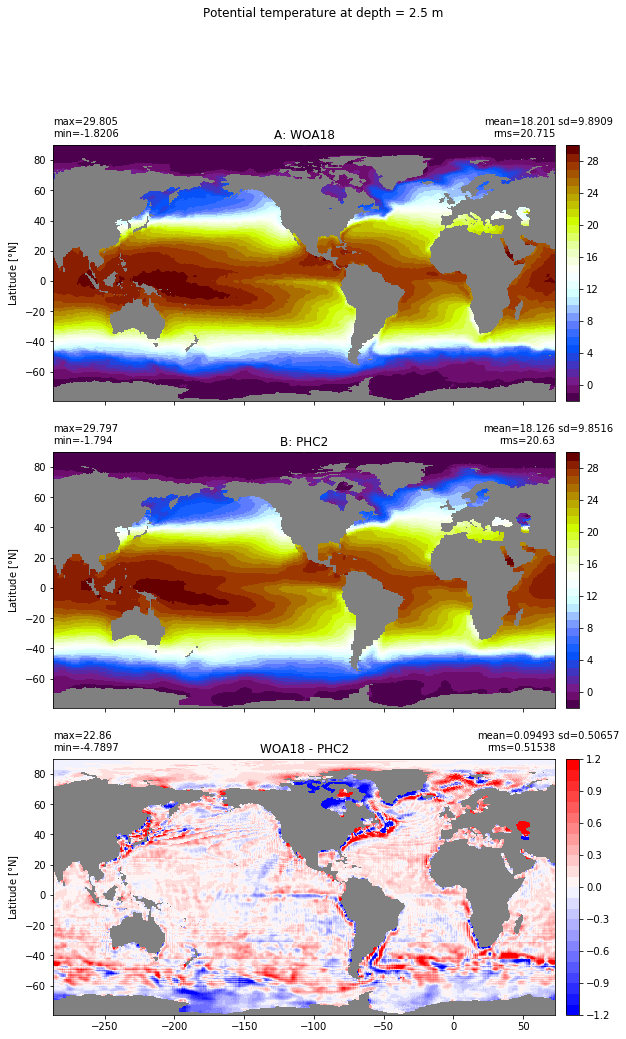

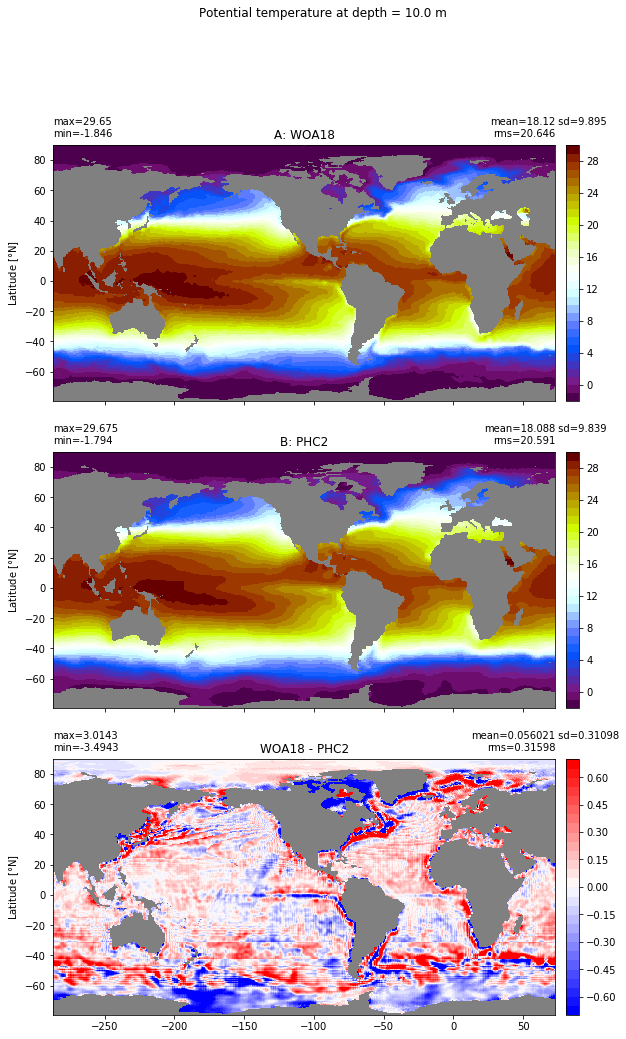

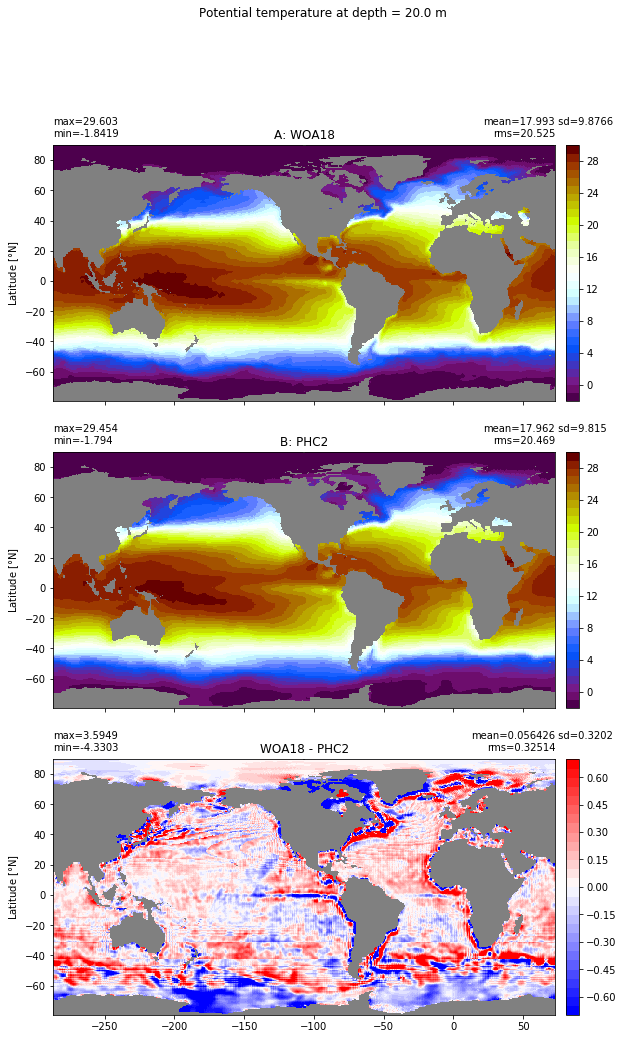

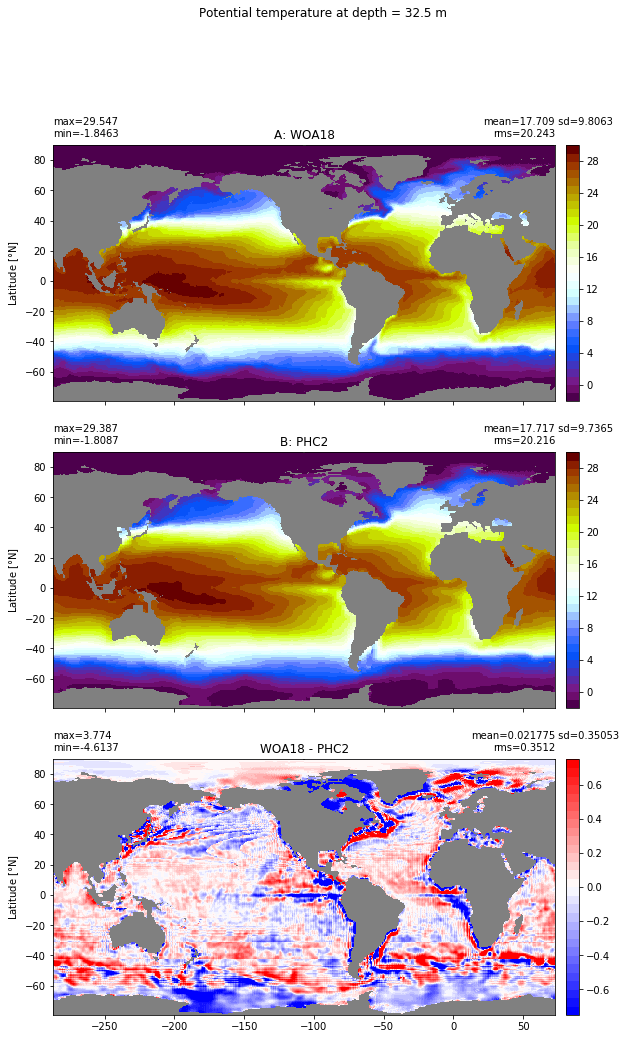

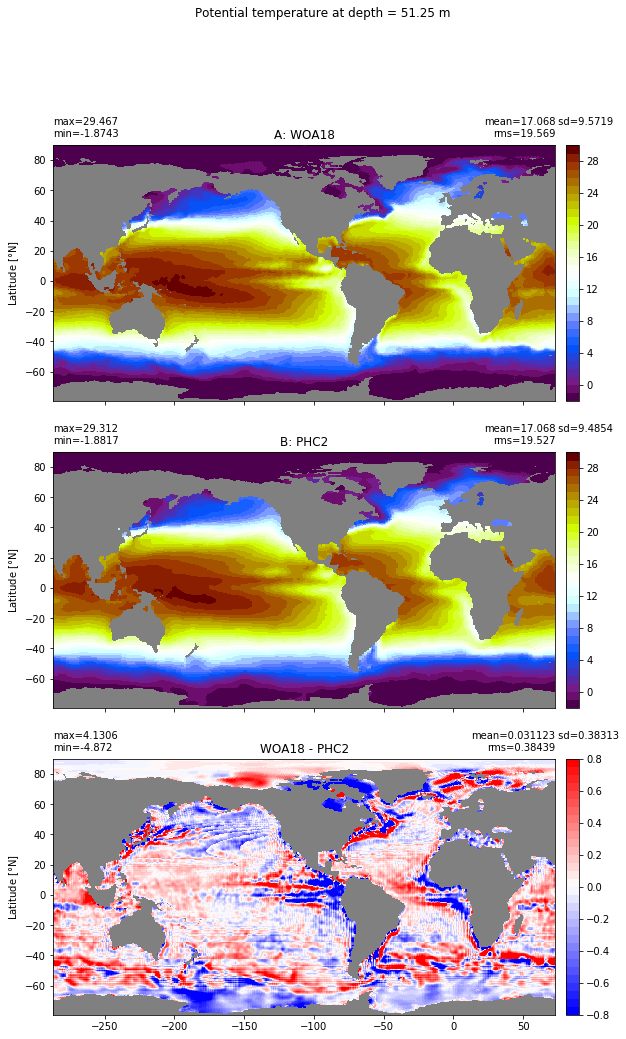

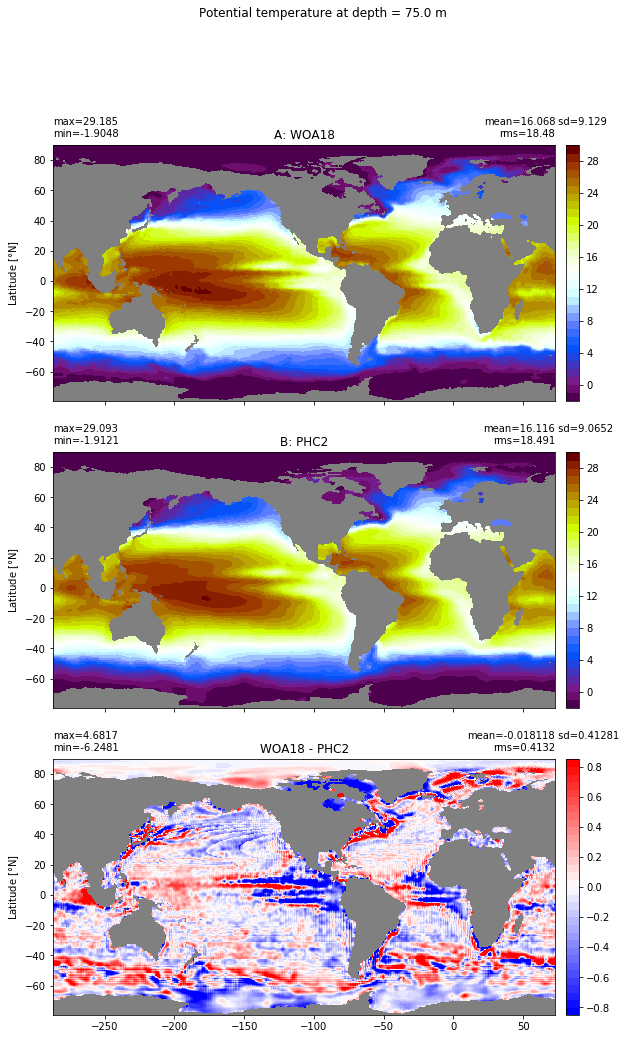

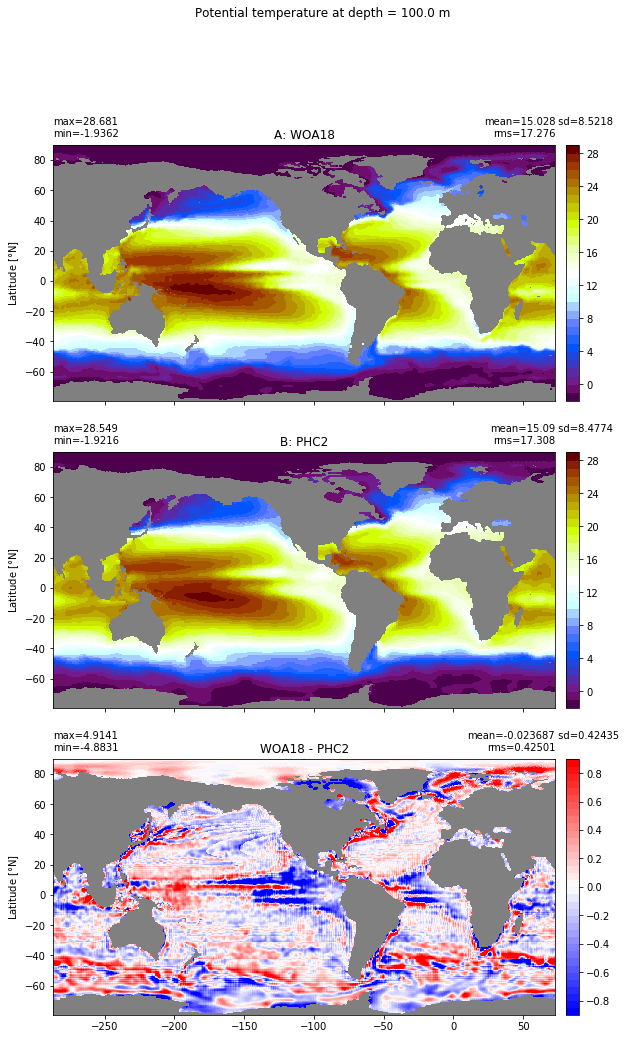

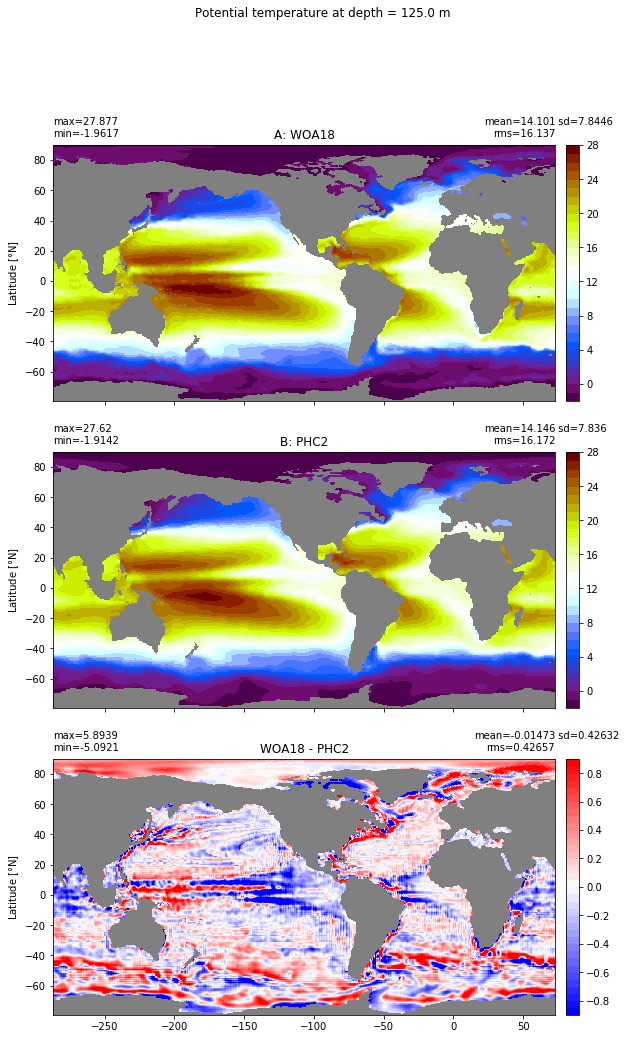

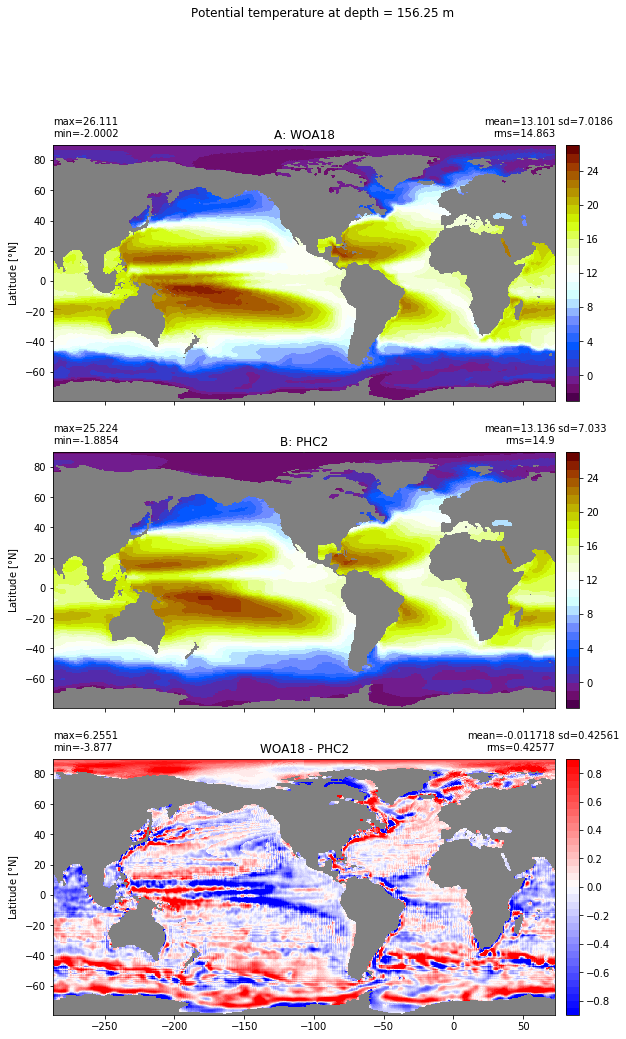

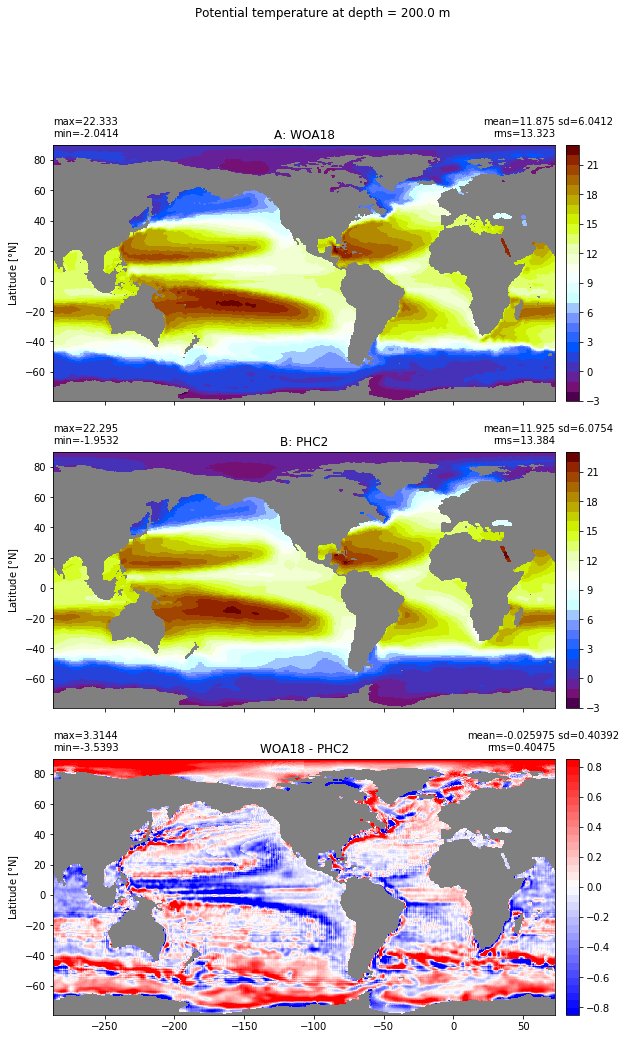

In [26]:
%matplotlib inline
km = temp_woa18.theta0.shape[0]
for k in range(10):
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,16))
  title = 'Potential temperature at depth = {} m'.format(temp_woa18.depth[k].values)
  dummy1 = np.ma.masked_invalid(temp_woa18.theta0[k,:].values)
  dummy2 = np.ma.masked_invalid(temp_phc2.theta0[k,:].values)
  area_tmp = np.ma.masked_where(dummy1.mask==True,grd.area_t)
  xycompare(dummy1,dummy2, grd.geolon, grd.geolat, area_tmp,title1='WOA18',title2='PHC2',
           title3='WOA18 - PHC2',axis=ax, suptitle=title, dcolormap=plt.cm.bwr)

### Salinity @ first 10 levels

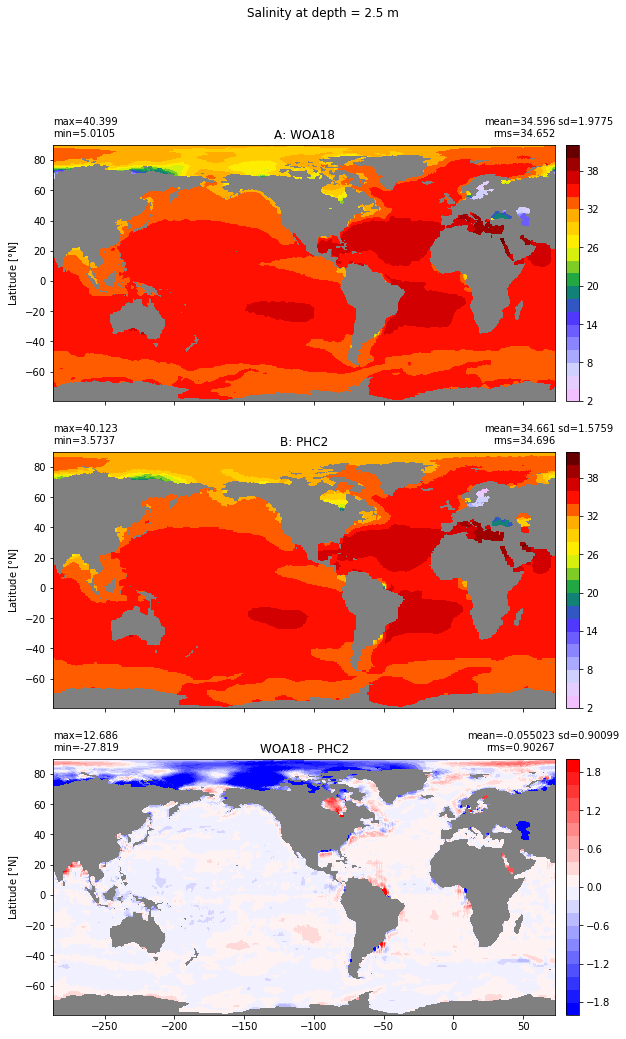

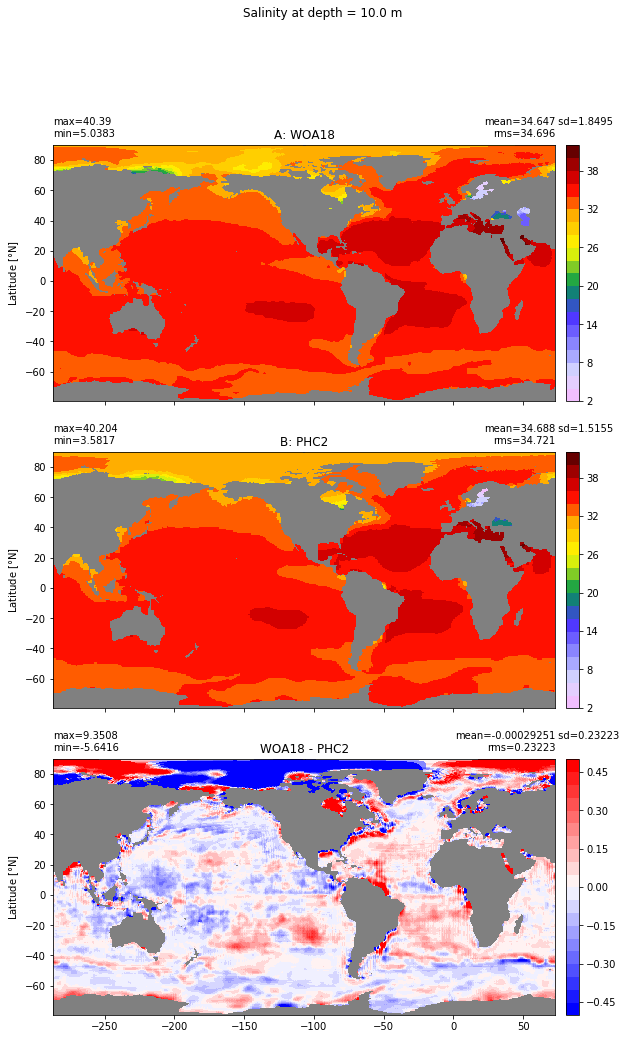

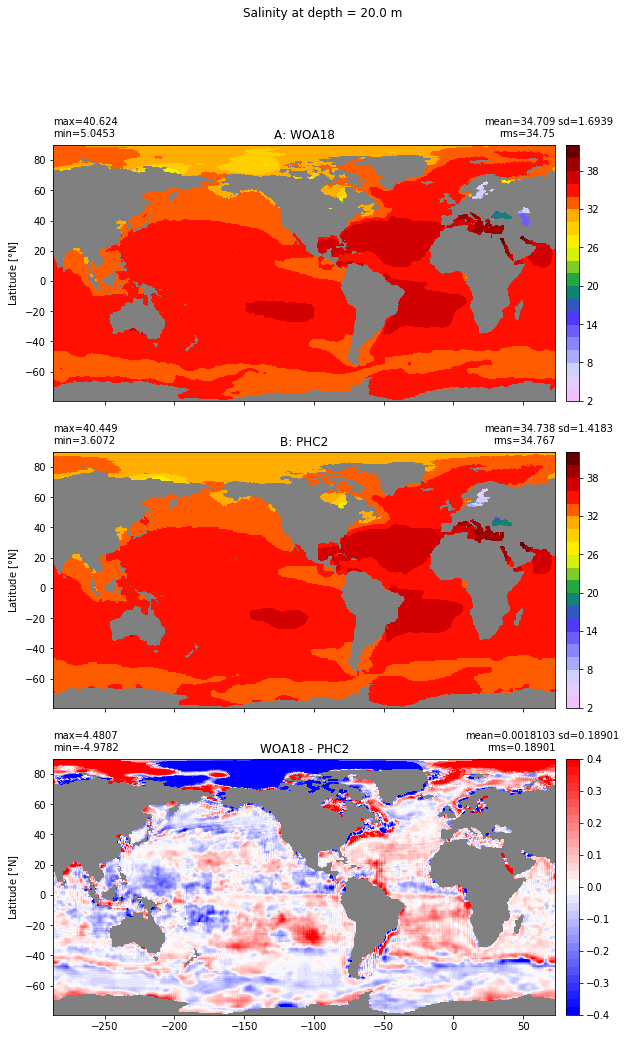

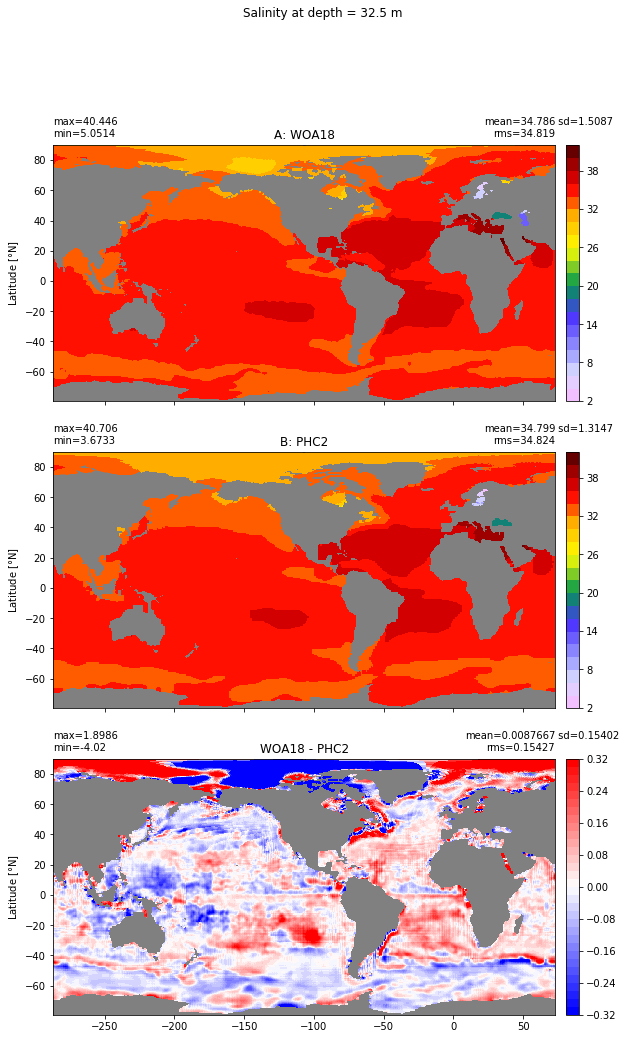

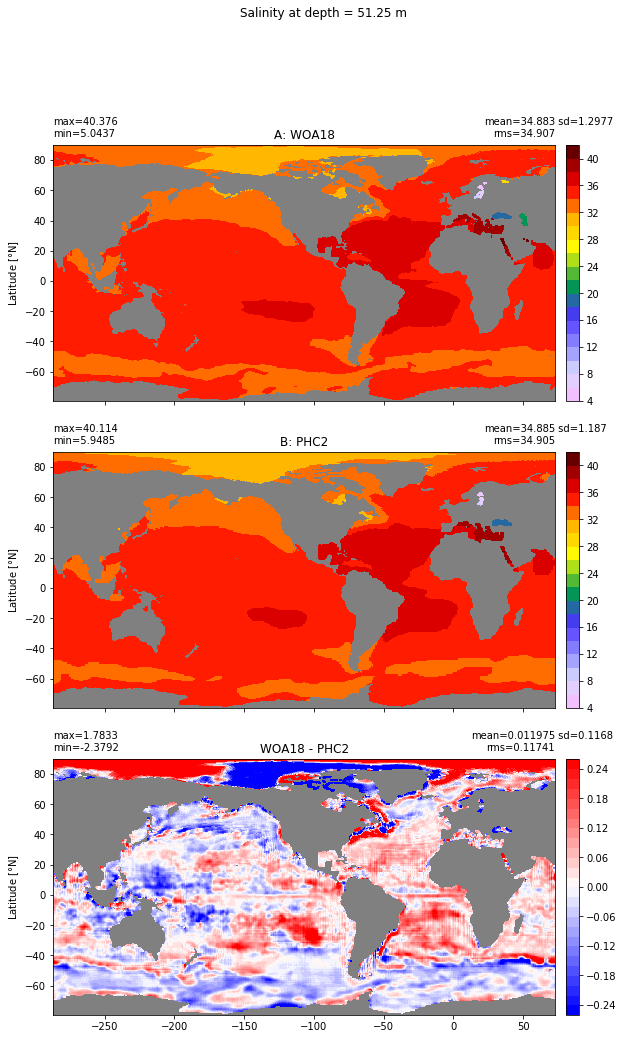

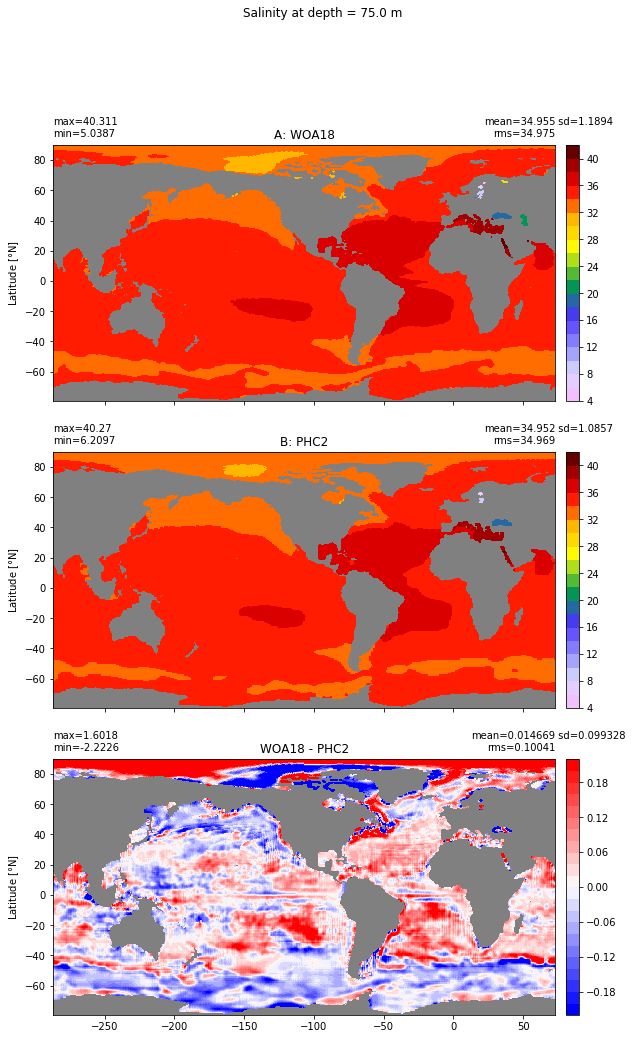

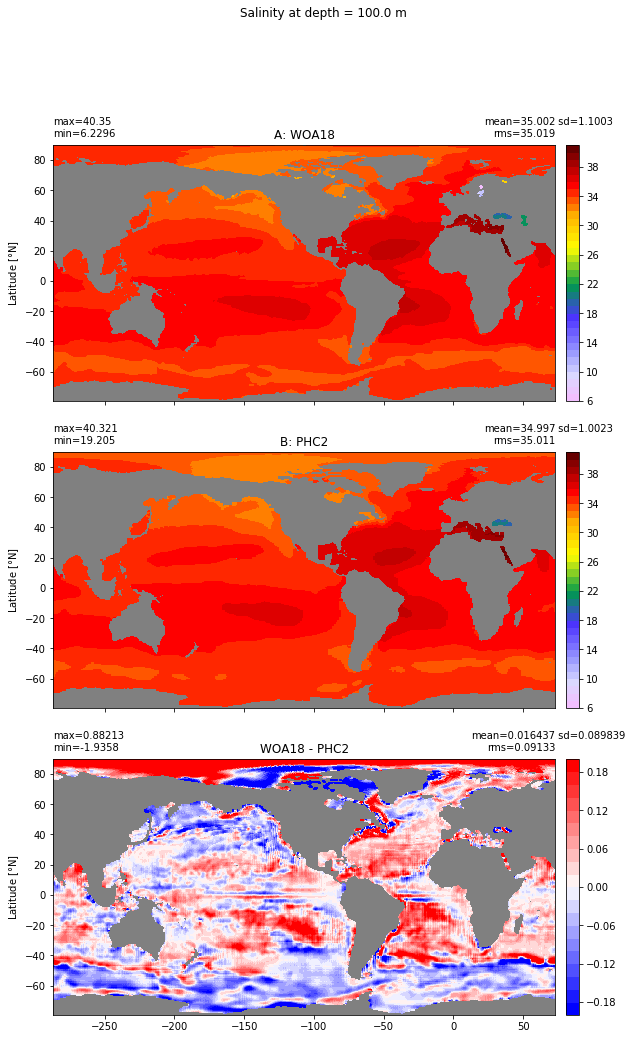

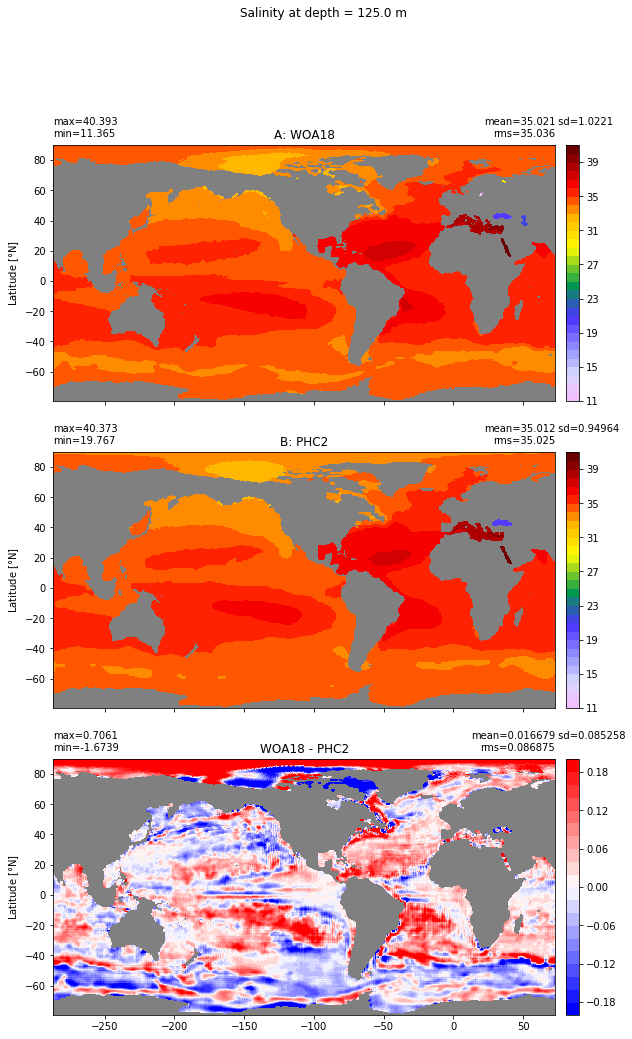

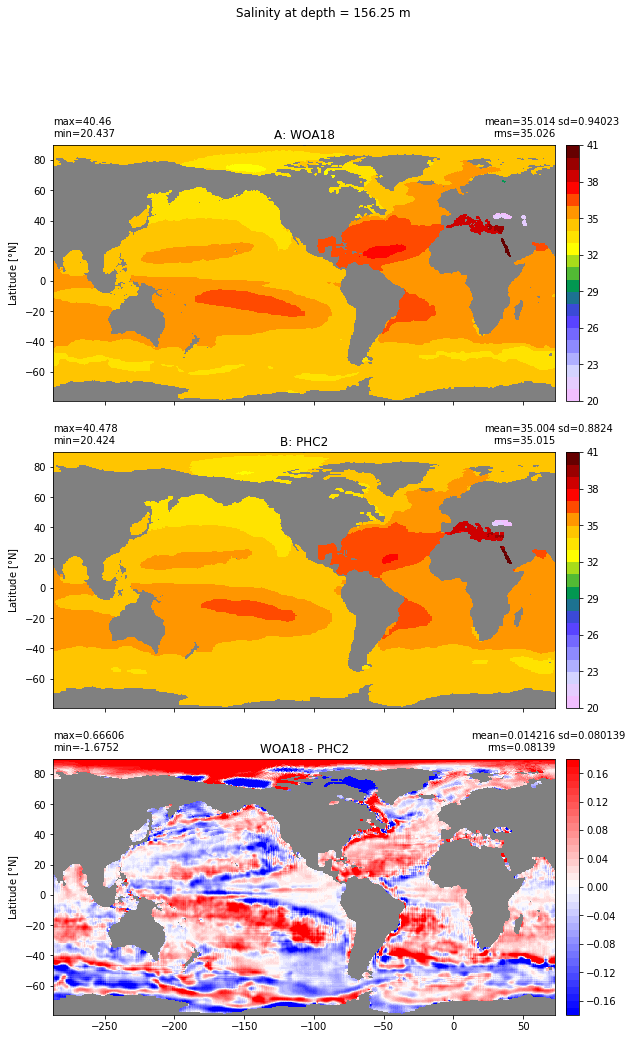

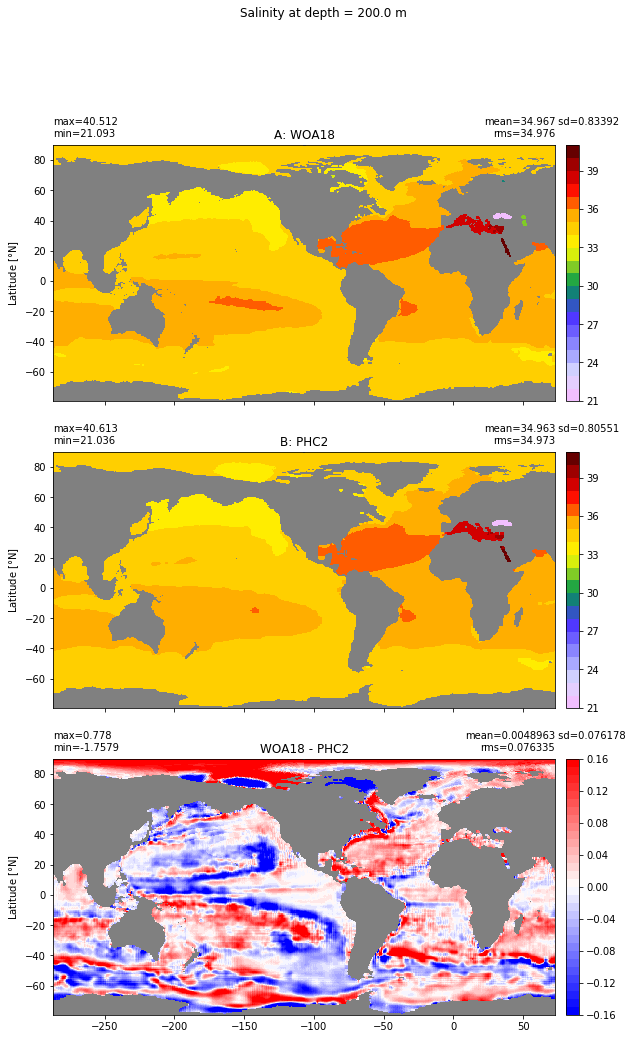

In [27]:
%matplotlib inline
for k in range(10):
  fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(10,16))
  title = 'Salinity at depth = {} m'.format(temp_woa18.depth[k].values)
  dummy1 = np.ma.masked_invalid(salt_woa18.s_an[k,:].values)
  dummy2 = np.ma.masked_invalid(salt_phc2.s_an[k,:].values)
  area_tmp = np.ma.masked_where(dummy1.mask==True,grd.area_t)
  xycompare(dummy1,dummy2, grd.geolon, grd.geolat, area_tmp,title1='WOA18',title2='PHC2',
           title3='WOA18 - PHC2',axis=ax, suptitle=title, dcolormap=plt.cm.bwr)